In [1]:
import os
import face_recognition
import json

# Path to dataset folder (Each folder inside is named after the person)
DATASET_PATH = "face-recognition-dataset/1/Original Images/Original Images"

encodings_dict = {}  # Dictionary to store encodings

# Loop through each folder (Each folder is a person)
for person_name in os.listdir(DATASET_PATH):
    person_path = os.path.join(DATASET_PATH, person_name)

    if not os.path.isdir(person_path):  # Skip non-folder files
        continue

    print(f"Processing {person_name}...")

    encodings = []  # Store multiple encodings for each person

    # Loop through each image inside the person's folder
    for image_name in os.listdir(person_path):
        image_path = os.path.join(person_path, image_name)

        try:
            # Load and encode the face
            image = face_recognition.load_image_file(image_path)
            face_encodings = face_recognition.face_encodings(image)

            if face_encodings:
                encodings.append(face_encodings[0])  # Store first detected face encoding
        except Exception as e:
            print(f"Error processing {image_name}: {e}")

    if encodings:
        encodings_dict[person_name] = [list(encoding) for encoding in encodings]  # Convert NumPy arrays to lists

# Save encodings to a JSON file
with open("encodings.json", "w") as f:
    json.dump(encodings_dict, f)

print("✅ Face encodings saved successfully!")


Processing Akshay Kumar...
Processing Alexandra Daddario...
Processing Alia Bhatt...
Processing Amitabh Bachchan...
Processing Andy Samberg...
Processing Anushka Sharma...
Processing Billie Eilish...
Processing Brad Pitt...
Processing Camila Cabello...
Processing Charlize Theron...
Processing Claire Holt...
Processing Courtney Cox...
Processing Dwayne Johnson...
Processing Elizabeth Olsen...
Processing Ellen Degeneres...
Processing Henry Cavill...
Processing Hrithik Roshan...
Processing Hugh Jackman...
Processing Jessica Alba...
Processing Kashyap...
Processing Lisa Kudrow...
Processing Margot Robbie...
Processing Marmik...
Processing Natalie Portman...
Processing Priyanka Chopra...
Processing Robert Downey Jr...
Processing Roger Federer...
Processing Tom Cruise...
Processing Vijay Deverakonda...
Processing Virat Kohli...
Processing Zac Efron...
✅ Face encodings saved successfully!


In [2]:
import face_recognition
import json
import numpy as np
import cv2

# Load known face encodings from JSON file
with open("encodings.json", "r") as f:
    known_faces = json.load(f)

# Convert stored lists back to NumPy arrays
for person in known_faces:
    known_faces[person] = [np.array(enc) for enc in known_faces[person]]

# Load the group image
group_image = face_recognition.load_image_file("billie_group_photo.jpg")
group_image_cv = cv2.cvtColor(group_image, cv2.COLOR_RGB2BGR)  # Convert to OpenCV format

# Detect all face locations and encodings in the group image
face_locations = face_recognition.face_locations(group_image)
unknown_encodings = face_recognition.face_encodings(group_image, face_locations)

if not unknown_encodings:
    print("No faces detected in the image!")
else:
    print("Matching detected faces...")
    log_results = []

    for face_encoding, (top, right, bottom, left) in zip(unknown_encodings, face_locations):
        best_match = None
        lowest_distance = 0.6  # Threshold (Lower = stricter)

        # Compare with all known faces
        for person_name, encodings in known_faces.items():
            results = face_recognition.compare_faces(encodings, face_encoding)
            distances = face_recognition.face_distance(encodings, face_encoding)

            if any(results):  # If at least one match is found
                best_idx = np.argmin(distances)  # Get best match index
                if distances[best_idx] < lowest_distance:
                    lowest_distance = distances[best_idx]
                    best_match = person_name

        # Draw bounding box and label
        label = best_match if best_match else "Unknown"
        color = (0, 255, 0) if best_match else (0, 0, 255)  # Green for known, red for unknown
        cv2.rectangle(group_image_cv, (left, top), (right, bottom), color, 2)
        cv2.putText(group_image_cv, label, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

        # Log results
        log_results.append({"coordinates": (top, right, bottom, left), "name": label})

        if best_match:
            print(f"✅ Identified: {best_match}")
        else:
            print("❌ No match found for a face")

    # Save log results
    with open("results_log.json", "w") as log_file:
        json.dump(log_results, log_file)

    # Save image with bounding boxes
    cv2.imwrite("output_group_image.jpg", group_image_cv)
    print("✅ Image with bounding boxes saved as output_group_image.jpg")

    # Show image (Optional)
    cv2.imshow("Face Recognition", group_image_cv)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


Matching detected faces...
❌ No match found for a face
❌ No match found for a face
✅ Identified: Elizabeth Olsen
✅ Identified: Billie Eilish
❌ No match found for a face
✅ Image with bounding boxes saved as output_group_image.jpg


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


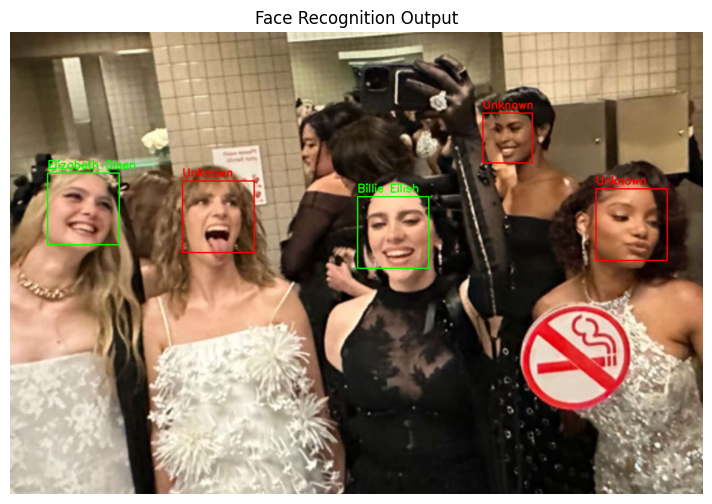

In [7]:
import matplotlib.pyplot as plt
import cv2

# Convert BGR (OpenCV format) to RGB (Matplotlib format)
group_image_rgb = cv2.cvtColor(group_image_cv, cv2.COLOR_BGR2RGB)

# Show the image
plt.figure(figsize=(10, 6))
plt.imshow(group_image_rgb)
plt.axis("off")  # Hide axes
plt.title("Face Recognition Output")
plt.show()


In [39]:
import cv2
import face_recognition
import numpy as np
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# ✅ Load known faces from JSON
with open("encodings.json", "r") as f:
    known_faces = json.load(f)

known_names = []
known_encodings = []

# Extract names and encodings correctly
for name, encodings in known_faces.items():
    for encoding in encodings:
        known_names.append(name)
        known_encodings.append(np.array(encoding))

known_encodings = np.array(known_encodings)

# ✅ Load or create attendance log
attendance_file = "attendance.xlsx"
if os.path.exists(attendance_file):
    attendance_df = pd.read_excel(attendance_file)
else:
    attendance_df = pd.DataFrame(columns=["Name", "Time", "Filename"])

# ✅ Folder for unknown faces
unknown_faces_dir = "unknown_faces"
os.makedirs(unknown_faces_dir, exist_ok=True)

# ✅ Dictionary to store today's unknown face encodings
unknown_faces_today = {}

# ✅ Start webcam
video_capture = cv2.VideoCapture(0)

plt.ion()  # Turn on interactive mode for Matplotlib

while True:
    ret, frame = video_capture.read()
    if not ret:
        print("❌ Failed to capture frame")
        break

    # Convert frame to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Detect faces
    face_locations = face_recognition.face_locations(rgb_frame)
    face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

    for face_encoding, (top, right, bottom, left) in zip(face_encodings, face_locations):
        matches = face_recognition.compare_faces(known_encodings, face_encoding)
        name = "Unknown"
        filename = ""

        # ✅ If a match is found, assign name
        if True in matches:
            match_index = np.where(matches)[0][0]  # Get first match index
            name = known_names[match_index]

            # ✅ Check if already recorded today
            current_date = datetime.now().strftime("%Y-%m-%d")
            if not attendance_df[
                (attendance_df["Name"] == name) & (attendance_df["Time"].str.startswith(current_date))
            ].empty:
                print(f"📌 {name} is already recorded today.")
                continue  # Skip logging this person again

        else:
            # ✅ Check if unknown face was already recorded today
            already_saved = False
            for saved_encoding in unknown_faces_today.values():
                match = face_recognition.compare_faces([saved_encoding], face_encoding, tolerance=0.6)
                if match[0]:  # If this face is similar to a saved one
                    already_saved = True
                    break
            
            if already_saved:
                print("📌 This unknown face was already saved today.")
                continue  # Skip saving & logging again

            # 📸 Save unknown face image
            timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            filename = f"unknown_{timestamp}.jpg"
            filepath = os.path.join(unknown_faces_dir, filename)
            face_crop = frame[top:bottom, left:right]
            if face_crop.size > 0:
                cv2.imwrite(filepath, face_crop)
                print(f"🚨 Unknown face saved: {filename}")

                # ✅ Store this unknown face encoding to avoid duplicates
                unknown_faces_today[filename] = face_encoding

        # 📝 Log attendance
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        new_entry = pd.DataFrame([[name, timestamp, filename]], columns=["Name", "Time", "Filename"])
        attendance_df = pd.concat([attendance_df, new_entry], ignore_index=True)
        attendance_df.to_excel(attendance_file, index=False)
        print(f"✅ {name} recorded at {timestamp}")

        # Draw bounding box
        color = (0, 255, 0) if name != "Unknown" else (0, 0, 255)  # Green for known, red for unknown
        cv2.rectangle(frame, (left, top), (right, bottom), color, 2)
        cv2.putText(frame, name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # ✅ Display frame using Matplotlib
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.draw()
    plt.pause(0.01)  # Pause for smooth updates
    plt.clf()  # Clear figure for next frame

    # Press any key to exit
    if plt.waitforbuttonpress(0.01):  
        break

# Cleanup
video_capture.release()
plt.close()
print("✅ Attendance system closed.")

❌ Failed to capture frame
✅ Attendance system closed.
